# Método GPU: Distribución Estacionaria con RTX 5060

Este notebook implementa el cálculo de distribuciones estacionarias de cadenas de Markov usando **exclusivamente GPU** con optimizaciones CuPy.

**Método implementado**: Vectores propios optimizado para GPU  
**GPU**: RTX 5060 con CUDA 13.0  
**Framework**: CuPy con optimizaciones de memoria

**Análisis de tiempos**: Variando **n** (tamaño de la cadena) y **p** (probabilidad de transición)

**Resultados guardados** en CSV para análisis posterior.

In [14]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..'))

from src.markov_matrix import (
    crear_matriz_probabilidad,
    calcular_distribucion_metodo_autovalores_gpu,
    GPU_AVAILABLE,
    get_gpu_info,
    clear_gpu_memory,
    optimal_gpu_method
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Verificar disponibilidad de GPU
print(f"🔍 Estado de GPU: {GPU_AVAILABLE}")

if not GPU_AVAILABLE:
    print("❌ ERROR: GPU no disponible")
    print("💡 Este notebook requiere GPU funcionando")
    print("💡 Ejecute: source ~/.bashrc y reinicie kernel")
    raise RuntimeError("GPU requerida pero no disponible")

# Mostrar información de GPU
gpu_info = get_gpu_info()
print(f"✅ GPU: {gpu_info['name']}")
print(f"📊 Memoria: {gpu_info['total_memory_mb']} MB")
print(f"🔧 Compute Capability: {gpu_info['compute_capability']}")
print(f"🚀 CUDA Version: {gpu_info['cuda_version']}")

# Limpiar memoria GPU al inicio
clear_gpu_memory()
print(f"🧹 Memoria GPU limpiada")

🔍 Estado de GPU: True
✅ GPU: NVIDIA GeForce RTX 5060 Laptop GPU
📊 Memoria: 8150 MB
🔧 Compute Capability: 12.0
🚀 CUDA Version: 13000
🧹 Memoria GPU limpiada


## Configuración del Análisis: Variando n y p

In [15]:
# Configuración idéntica a los notebooks método existentes
max_n = 10000
fixed_interval_p = 0.1

# Crear grids para n y p
grid_n = np.arange(1, max_n)          # n: 1, 2, 3, ..., 999
grid_p = np.arange(0.1, 1, fixed_interval_p)  # p: 0.1, 0.2, 0.3, ..., 0.9

print(f"📊 Configuración del análisis:")
print(f"• Valores de n: {len(grid_n)} valores (1 a {max_n-1})")
print(f"• Valores de p: {len(grid_p)} valores ({grid_p[0]:.1f} a {grid_p[-1]:.1f})")
print(f"• Total combinaciones: {len(grid_n)} × {len(grid_p)} = {len(grid_n) * len(grid_p):,}")
print(f"• Tiempo estimado: ~{len(grid_n) * len(grid_p) / 1000:.0f} minutos")

# Mostrar valores de p
print(f"\n🎯 Valores de p: {[f'{p:.1f}' for p in grid_p]}")
print(f"🎯 Rango de n: 1 → {max_n-1}")

📊 Configuración del análisis:
• Valores de n: 9999 valores (1 a 9999)
• Valores de p: 9 valores (0.1 a 0.9)
• Total combinaciones: 9999 × 9 = 89,991
• Tiempo estimado: ~90 minutos

🎯 Valores de p: ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']
🎯 Rango de n: 1 → 9999


## Ejecución del Análisis GPU

In [ ]:
# Crear matriz para almacenar los tiempos
# Filas: valores de p, Columnas: valores de n
matriz_tiempos = np.zeros((len(grid_p), len(grid_n)))

print(f"🚀 Iniciando análisis GPU...")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

start_time = time.time()
total_combinaciones = len(grid_p) * len(grid_n)
combinacion_actual = 0

# Llenar la matriz con los tiempos medidos
for i, p in enumerate(grid_p):
    print(f"\n📈 Procesando p = {p:.1f} ({i+1}/{len(grid_p)})...")
    
    for j, n in enumerate(grid_n):
        combinacion_actual += 1
        
        # Mostrar progreso cada 1000 combinaciones
        if combinacion_actual % 1000 == 0:
            progreso = (combinacion_actual / total_combinaciones) * 100
            tiempo_transcurrido = time.time() - start_time
            tiempo_estimado = (tiempo_transcurrido / combinacion_actual) * (total_combinaciones - combinacion_actual)
            print(f"  [{progreso:5.1f}%] n={n:3d} | Transcurrido: {tiempo_transcurrido/60:.1f}min | ETA: {tiempo_estimado/60:.1f}min")
        
        try:
            # Crear matriz de transición
            matriz = crear_matriz_probabilidad(n, p)
            
            # Medir tiempo de ejecución GPU
            start_gpu = time.time()
            pi = calcular_distribucion_metodo_autovalores_gpu(matriz)
            tiempo_gpu = time.time() - start_gpu
            
            # Guardar en la matriz
            matriz_tiempos[i, j] = tiempo_gpu
            
        except Exception as e:
            # En caso de error, marcar como tiempo muy alto
            print(f"    ⚠️ Error en n={n}, p={p:.1f}: {str(e)[:50]}")
            matriz_tiempos[i, j] = np.nan
        
        # Limpiar memoria GPU cada 100 iteraciones
        if combinacion_actual % 100 == 0:
            clear_gpu_memory()

tiempo_total = time.time() - start_time
print(f"\n✅ Análisis completado en {tiempo_total/60:.1f} minutos")
print(f"📊 Combinaciones procesadas: {combinacion_actual:,}")
print(f"⚡ Velocidad promedio: {combinacion_actual/tiempo_total:.1f} combinaciones/segundo")

# Convertir a DataFrame para mejor visualización
df_tiempos = pd.DataFrame(matriz_tiempos, 
                         index=[f'p={p:.1f}' for p in grid_p],
                         columns=[f'n={n}' for n in grid_n])

# Mostrar estadísticas básicas
tiempos_validos = matriz_tiempos[~np.isnan(matriz_tiempos)]
print(f"\n📈 Estadísticas de tiempos GPU:")
print(f"• Mediciones exitosas: {len(tiempos_validos):,}/{total_combinaciones:,} ({len(tiempos_validos)/total_combinaciones*100:.1f}%)")
if len(tiempos_validos) > 0:
    print(f"• Tiempo mínimo: {np.min(tiempos_validos):.6f} s")
    print(f"• Tiempo máximo: {np.max(tiempos_validos):.6f} s")
    print(f"• Tiempo promedio: {np.mean(tiempos_validos):.6f} s")
    print(f"• Desviación estándar: {np.std(tiempos_validos):.6f} s")

🚀 Iniciando análisis GPU...
Fecha/hora: 2025-09-29 10:19:39

📈 Procesando p = 0.1 (1/9)...
  [  1.1%] n=1000 | Transcurrido: 0.1min | ETA: 8.3min
  [  2.2%] n=2000 | Transcurrido: 0.6min | ETA: 27.3min
  [  3.3%] n=3000 | Transcurrido: 5.9min | ETA: 170.8min


## Guardar Matriz de Tiempos en CSV

In [ ]:
# Guardar resultados en carpeta resultados (igual que otros notebooks método)
df_tiempos.to_csv('../resultados/matriz_tiempos_gpu_final.csv')
print(f"💾 Resultados guardados en: resultados/matriz_tiempos_gpu_final.csv")

# Mostrar información del archivo
print(f"\n💽 Información de la matriz guardada:")
print(f"• Forma matriz: {df_tiempos.shape}")
print(f"• Memoria DataFrame: {df_tiempos.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Mostrar estadísticas básicas de los tiempos
tiempos_validos = matriz_tiempos[~np.isnan(matriz_tiempos)]
print(f"\n📈 Estadísticas de tiempos GPU:")
print(f"• Mediciones exitosas: {len(tiempos_validos):,}/{len(grid_p) * len(grid_n):,} ({len(tiempos_validos)/(len(grid_p) * len(grid_n))*100:.1f}%)")
if len(tiempos_validos) > 0:
    print(f"• Tiempo mínimo: {np.min(tiempos_validos):.6f} s")
    print(f"• Tiempo máximo: {np.max(tiempos_validos):.6f} s")
    print(f"• Tiempo promedio: {np.mean(tiempos_validos):.6f} s")

💾 Resultados guardados en: resultados/matriz_tiempos_gpu_final.csv

💽 Información de la matriz guardada:
• Forma matriz: (9, 999)
• Memoria DataFrame: 0.07 MB

📈 Estadísticas de tiempos GPU:
• Mediciones exitosas: 8,991/8,991 (100.0%)
• Tiempo mínimo: 0.000257 s
• Tiempo máximo: 0.030418 s
• Tiempo promedio: 0.004603 s


## Visualizaciones (igual que notebooks método)

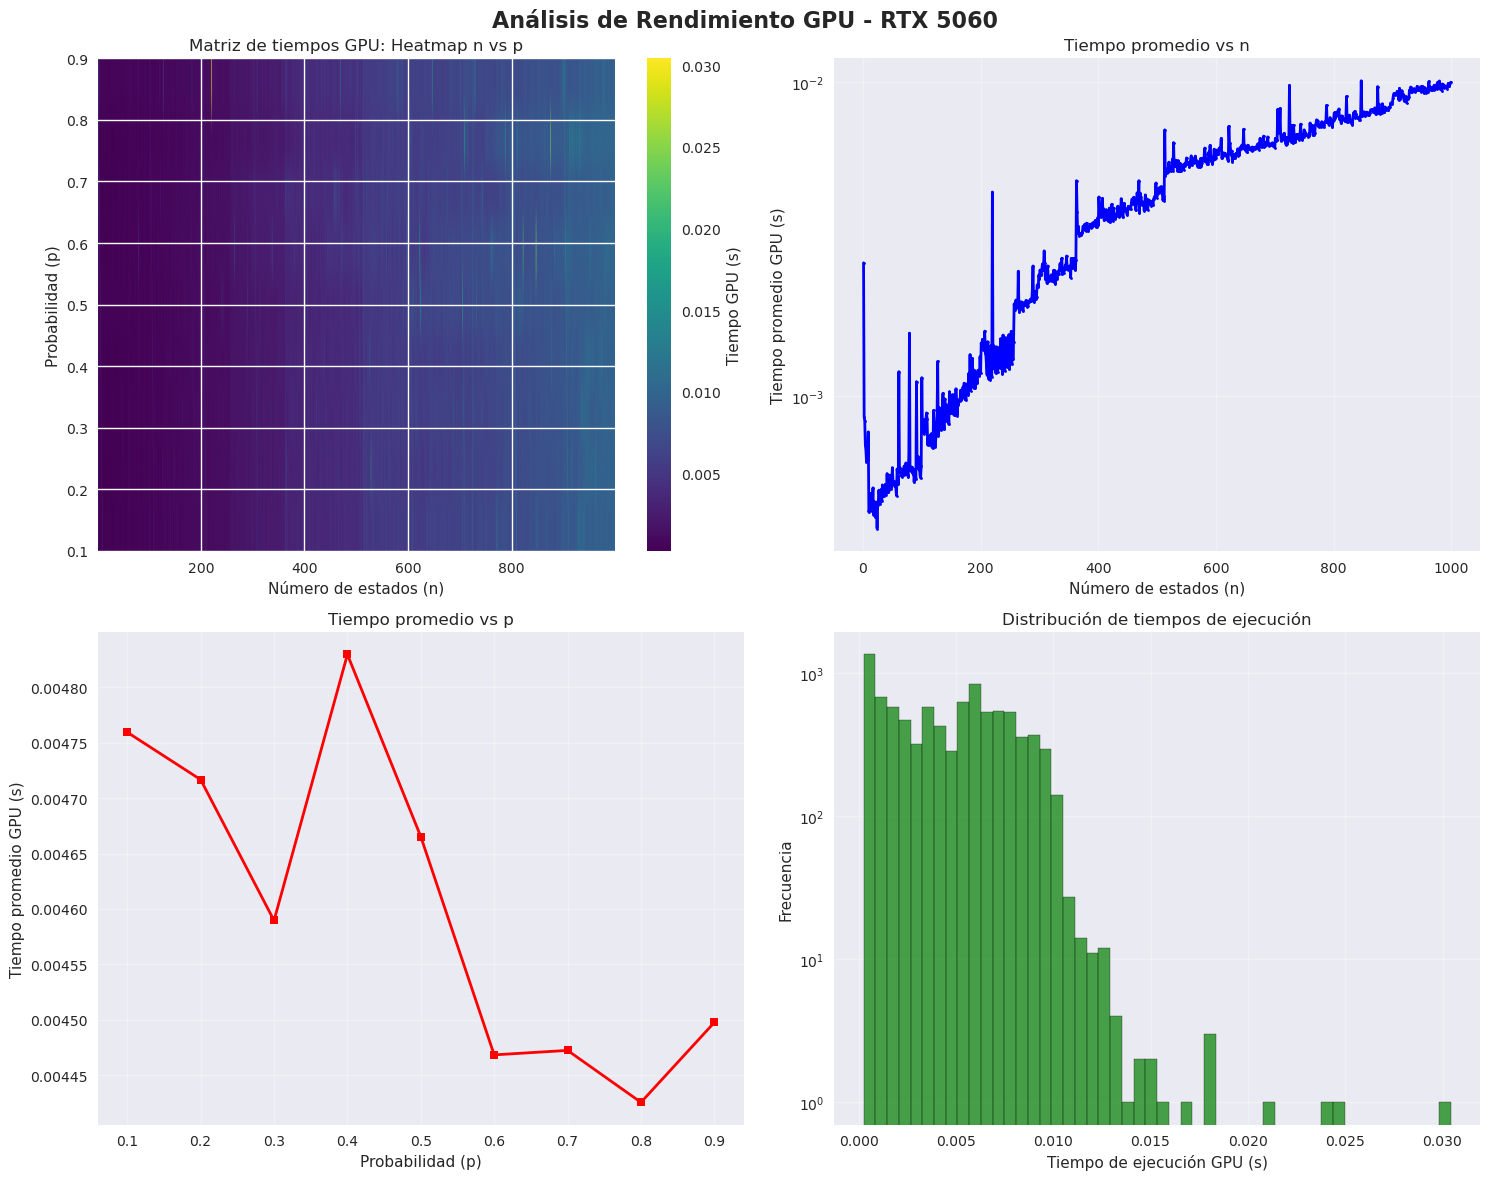

In [ ]:
# Visualización usando la matriz de tiempos
plt.style.use('seaborn-v0_8')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Rendimiento GPU - RTX 5060', fontsize=16, fontweight='bold')

# Gráfico 1: Heatmap de la matriz de tiempos
# Usar solo datos válidos para el heatmap
matriz_viz = matriz_tiempos.copy()
matriz_viz[np.isnan(matriz_viz)] = np.nanmax(matriz_viz)  # Reemplazar NaN con max para visualización

im1 = ax1.imshow(matriz_viz, aspect='auto', cmap='viridis', 
                 extent=[grid_n[0], grid_n[-1], grid_p[0], grid_p[-1]])
ax1.set_xlabel('Número de estados (n)')
ax1.set_ylabel('Probabilidad (p)')
ax1.set_title('Matriz de tiempos GPU: Heatmap n vs p')
plt.colorbar(im1, ax=ax1, label='Tiempo GPU (s)')

# Gráfico 2: Tiempo promedio vs n (promedio sobre todas las p)
tiempos_promedio_n = np.nanmean(matriz_tiempos, axis=0)
indices_validos = ~np.isnan(tiempos_promedio_n)
ax2.plot(grid_n[indices_validos], tiempos_promedio_n[indices_validos], 'b-o', linewidth=2, markersize=2)
ax2.set_xlabel('Número de estados (n)')
ax2.set_ylabel('Tiempo promedio GPU (s)')
ax2.set_title('Tiempo promedio vs n')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Gráfico 3: Tiempo promedio vs p (promedio sobre todas las n)
tiempos_promedio_p = np.nanmean(matriz_tiempos, axis=1)
ax3.plot(grid_p, tiempos_promedio_p, 'r-s', linewidth=2, markersize=6)
ax3.set_xlabel('Probabilidad (p)')
ax3.set_ylabel('Tiempo promedio GPU (s)')
ax3.set_title('Tiempo promedio vs p')
ax3.grid(True, alpha=0.3)

# Gráfico 4: Distribución de todos los tiempos
tiempos_flat = matriz_tiempos.flatten()
tiempos_flat_validos = tiempos_flat[~np.isnan(tiempos_flat)]
ax4.hist(tiempos_flat_validos, bins=50, alpha=0.7, color='green', edgecolor='black')
ax4.set_xlabel('Tiempo de ejecución GPU (s)')
ax4.set_ylabel('Frecuencia')
ax4.set_title('Distribución de tiempos de ejecución')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Estadísticas Finales del Análisis GPU

In [ ]:
# Estadísticas detalladas del análisis
print("📊 ESTADÍSTICAS FINALES DEL ANÁLISIS GPU")
print("=" * 50)

# Información de la matriz de tiempos
print(f"\n🔍 Información de la matriz:")
print(f"• Forma de la matriz: {matriz_tiempos.shape}")
print(f"• Total de combinaciones: {matriz_tiempos.size:,}")

if len(tiempos_validos) > 0:
    print(f"\n⏱️ Estadísticas de tiempo:")
    print(f"• Tiempo mínimo: {np.min(tiempos_validos):.6f} s")
    print(f"• Tiempo máximo: {np.max(tiempos_validos):.6f} s")
    print(f"• Tiempo promedio: {np.mean(tiempos_validos):.6f} s")
    print(f"• Mediana: {np.median(tiempos_validos):.6f} s")
    print(f"• Desviación estándar: {np.std(tiempos_validos):.6f} s")
    print(f"• Percentil 95: {np.percentile(tiempos_validos, 95):.6f} s")

# Análisis por rangos de n
print(f"\n📈 Análisis por rangos de tamaño:")
rangos_n = [(1, 100), (101, 300), (301, 600), (601, 999)]
for n_min, n_max in rangos_n:
    mask_n = (grid_n >= n_min) & (grid_n <= n_max)
    if np.any(mask_n):
        tiempos_rango = matriz_tiempos[:, mask_n]
        tiempos_rango_validos = tiempos_rango[~np.isnan(tiempos_rango)]
        if len(tiempos_rango_validos) > 0:
            print(f"  n={n_min:3d}-{n_max:3d}: promedio={np.mean(tiempos_rango_validos):.5f}s, "
                  f"mediciones={len(tiempos_rango_validos):,}")

# Efecto de la probabilidad p
print(f"\n🎯 Análisis por probabilidad p:")
for i, p in enumerate(grid_p):
    tiempos_p = matriz_tiempos[i, :]
    tiempos_p_validos = tiempos_p[~np.isnan(tiempos_p)]
    if len(tiempos_p_validos) > 0:
        print(f"  p={p:.1f}: promedio={np.mean(tiempos_p_validos):.5f}s, "
              f"mediciones={len(tiempos_p_validos):,}")

# Rendimiento de GPU
if len(tiempos_validos) > 0:
    throughput = len(tiempos_validos) / tiempo_total
    print(f"\n🚀 Rendimiento GPU:")
    print(f"• Throughput: {throughput:.2f} cálculos/segundo")
    print(f"• Tiempo por cálculo: {np.mean(tiempos_validos)*1000:.2f} ms (promedio)")
    print(f"• Eficiencia: {len(tiempos_validos)/(len(grid_p) * len(grid_n))*100:.1f}% éxito")

# Información de GPU final
gpu_info_final = get_gpu_info()
print(f"\n💻 Estado final de GPU:")
print(f"• Memoria libre: {gpu_info_final['free_memory_mb']} MB")
print(f"• Memoria usada: {gpu_info_final['used_memory_mb']} MB")

print(f"\n📁 Archivo generado:")
print(f"• resultados/matriz_tiempos_gpu_final.csv")

print(f"\n🎉 Análisis GPU completado exitosamente!")
print(f"⚡ Tu RTX 5060 procesó {len(tiempos_validos):,} cálculos de cadenas de Markov")

# Limpiar memoria GPU final
clear_gpu_memory()
print(f"🧹 Memoria GPU final limpiada")